#### Optional Install mpld3 for interactive plots
(Note: You may need to restart the kernel after installing)

In [2]:
pip install mpld3

     |████████████████████████████████| 888 kB 20.6 MB/s eta 0:00:01
  Created wheel for mpld3: filename=mpld3-0.5.2-py3-none-any.whl size=200617 sha256=520c7029ebe0069faf2b51a2ae4b1b2df2fbb055a91c9557884d07cb2d681798
  Stored in directory: /home/jovyan/.cache/pip/wheels/11/af/f9/b3fc6166b9a794dcde7e64b183d48d495aa0f5e469d73ef385
Successfully built mpld3
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import mpld3
%matplotlib inline
import mpld3
mpld3.enable_notebook()

#### Import common libraries

In [4]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Datalake Login

In [5]:
from minio import Minio
client = Minio('3.235.68.217:9000',
access_key='<username>',
secret_key='<secret_key>',
secure=False)

#### Import Data From Datalake

In [6]:
unit_prices = client.get_object('datalake', '<username>/Benchmark_data/UnitPrice_and_BenchmarkData/unit_prices.csv')
benchmarks = client.get_object('datalake', '<username>/Benchmark_data/UnitPrice_and_BenchmarkData/benchmarks.csv')

#### Data Preparation

In [7]:
# load unit prices and benchmarks
unit_prices_raw = pd.read_csv(unit_prices)
benchmarks_raw = pd.read_csv(benchmarks)

# convert dates to datetime
unit_prices_raw['ValueDate'] = pd.to_datetime(unit_prices_raw['ValueDate'])
benchmarks_raw['ValueDate'] = pd.to_datetime(benchmarks_raw['ValueDate'])

In [8]:
# reformat dataframe with funds / benchmarks as columns
benchmarks = pd.DataFrame(index=benchmarks_raw.ValueDate.unique())
for k, g in benchmarks_raw.groupby("BenchmarkCode"):    
    benchmarks[k] = g.set_index("ValueDate")['IndexClose_BASE']    
    
unit_prices = pd.DataFrame(index=benchmarks_raw.ValueDate.unique())
for k, g in unit_prices_raw.groupby("PriceCode"):    
    try:
        unit_prices[k] = g.set_index("ValueDate")['NetNAVPrice']
    except ValueError:
        pass  # ignore funds with duplicate index

In [9]:
benchmarks.sort_index(inplace=True)
unit_prices.sort_index(inplace=True)

In [10]:
apdas = unit_prices['APDAS'].dropna()
apdalt = unit_prices['APDALT'].dropna()
nzpbal = unit_prices['NZPBAL'].dropna()

# remove constant prices
apdalt = apdalt.loc[(apdalt.index < '2020-01-01') & (apdalt.index > '2018-06-30')]  

In [11]:
def prepare_fund_and_bench(fund, benchmarks, min_not_na=800):        
    """ Align fund and benchmark dates 
    Args:
        fund: Series containg fund prices over time.
        benchmarks: Dataframe containing benchmark prices over time.
        min_not_na: Threshold for excluding benchmarks with too many NaNs.
        
    Returns:
        Aligned fund and benchmark data.   
    """    
    # get benchmarks with enough data    
    bench_cols = benchmarks.columns[benchmarks.loc[fund.index].notna().sum()>=min_not_na]
    benchdata = benchmarks.loc[fund.index, bench_cols].dropna()
    return fund.loc[benchdata.index], benchdata

#### Fit Model

In [12]:
import statsmodels.api as sm

class BenchMapper:
    def __fit(self, y, X, alpha=0.05):
        """ Fit returns based on benchmark data. """    
        self.drop = []
        
        # Use p-value feature selection    
        while X.shape[1] > 0:                            
            model = sm.OLS(y, sm.add_constant(X.drop(self.drop, axis=1))).fit(disp=0)
            pvalues = model.pvalues.drop(['const'])            
            
            try:
                remove = pvalues.idxmax()  # x with max p-value
                pval = pvalues[remove]
            except:                
                model = sm.OLS(y, sm.add_constant(X[[]])).fit(disp=0)
                self.drop = list(X.columns)
                
                #print(model.summary())
                #print(X.tail())
                #print(y)
                break
                
            if pval < alpha:
                break

            self.drop.append(remove)

        self.model = model

    def __returns_to_prices(self, returns):
        """ Converts returns to price values. """           
        return self.fund.shift(1).loc[returns.index, self.price_col] * (1 + (returns/100))    
        
    def fit(self, alpha=0.05):
        """ Train using the first ndays. """
        X = self.benchmarks[:self.ndays]
        y = self.fund_returns[:self.ndays]
        self.__fit(y, X, alpha)
        
    def summary(self):
        """ Returns a pretty summary. """
        return self.model.summary()
    
    def __predict(self, X, alpha):
        """ Predicts returns based on fitted model (static) """
        prediction = self.model.get_prediction(sm.add_constant(X.drop(self.drop, axis=1), has_constant='add'))
        frame = prediction.summary_frame(alpha=alpha)
        return frame['mean'], frame.obs_ci_lower, frame.obs_ci_upper

    def __predict_rolling(self, X, y, alpha):
        """ Predicts returns for next day and then refits the model. """
        Xtrain = self.benchmarks[:self.ndays]
        ytrain = self.benchmarks[:self.ndays]
        
        # merge dataset
        Xfull = pd.concat([Xtrain, X], axis=0)
        yfull = pd.concat([ytrain, y], axis=0)
        
        start = self.ndays
        end = self.ndays + self.ndays
        
        prediction = self.model.get_prediction(sm.add_constant(X.drop(self.drop, axis=1))[:1])
        frame = prediction.summary_frame(alpha=alpha)
        return frame['mean'], frame.obs_ci_lower, frame.obs_ci_upper
                
    def fit_predict_rolling(self, to_prices=True, alpha=0.05):
        """ Fits a model and predicts on a rolling basis. 
        
        Args:
            to_prices (bool): If true, convert to prices before retaurning.
            alpha (float): Significance level.
        
        Returns:
            prediction, lower CI, upper CI            
        """
        X = self.benchmarks  # exog
        y = self.fund_returns  # endog
        #coeffs = pd.DataFrame(columns=list(range(X.shape[1])), index=X.index)
        coeffs = pd.DataFrame(columns=X.columns, index=X.index)
        coeffs['const'] = np.nan

        N = X.shape[0]
        y_pred, y_lci, y_uci = [pd.Series()]*3        
        
        for i in range(self.ndays, N):
            tstart, tend = i-self.ndays, i  # training range        
            Xtrain = X[tstart:tend]
            
            #pca = PCA(n_components=5)            
            #pca.fit(X)
            #Xtrain = pd.DataFrame(index=Xtrain.index, data=pca.transform(Xtrain))
            
            ytrain = y[tstart:tend]
            
            if Xtrain.shape[0] < Xtrain.shape[1]:
                break
                
            # fit the model            
            self.__fit(ytrain, Xtrain, alpha)
            params = self.model.params.index  # list of non-zero beta coeffs            
            pframe = self.model.params.to_frame().T  # convert to dataframe
            if y_pred.empty:  # first ndays
                # init coeffs for first training period
                coeffs.loc[Xtrain.index, params] = pframe.loc[pframe.index.repeat(Xtrain.shape[0])].set_index(Xtrain.index)                                
            else:
                # set coeffs for most recent period
                coeffs.loc[Xtrain.tail(1).index, params] = self.model.params.to_frame().T.set_index(Xtrain.tail(1).index)
            
            Xtest = X[:i+1] if y_pred.empty else X[i:i+1]  # predict the next day
            #Xtest =  pd.DataFrame(index=Xtest.index, data=pca.transform(Xtest))
            
            y_pred_i, y_lci_i, y_uci_i = self.__predict(Xtest, alpha)
            
            y_pred = y_pred.append(y_pred_i)
            y_lci = y_lci.append(y_lci_i)
            y_uci = y_uci.append(y_uci_i)
        
        # save non-null coeffs
        self.coeffs = coeffs.loc[:, (coeffs.notna()).any()].fillna(0)
        
        if to_prices:
            self.y_pred, self.y_lci, self.y_uci = self.__returns_to_prices(y_pred), \
                                                  self.__returns_to_prices(y_lci), \
                                                  self.__returns_to_prices(y_uci)
        else:
            self.y_pred, self.y_lci, self.y_uci = y_pred, y_lci, y_uci
        
        return self.y_pred, self.y_lci, self.y_uci
        
    def predict(self, X, alpha=0.05):
        """ Predicts returns based on fitted model. 
            
        Args:
            X (dataframe): Benchmark data to predict from.            
            alpha (float): Significance level.
        Returns:
            prediction, lower CI, upper CI            
        """
        return self.__predict(X, alpha)
    
    
    def predict_price(self, X, alpha=0.05):
        """ Predicts returns based on fitted model and transforms 
        the result into a price value.
        
        Args:
            X (dataframe): Benchmark data to predict from.            
            alpha (float): Significance level.
        Returns:
            prediction, lower CI, upper CI (prices)      
        """
        pred, lci, uci = self.predict(X, alpha)
        return self.__returns_to_prices(pred), \
               self.__returns_to_prices(lci), \
               self.__returns_to_prices(uci)
        
    def plot(self, start=0, end=-1):    
        """ Plots the predicted and true prices for a specified date range. 
        
        Args: 
            start (int): Starting index.
            end (int): Ending index
        """
        
        y_pred, y_lci, y_uci = self.y_pred, self.y_lci, self.y_uci
        y_true = self.fund[self.price_col].loc[y_pred.index]          
        
        fig, ax = plt.subplots(figsize=(20,10))
        ax.grid(True, alpha=0.3)        
        plt.xlabel("Date", fontsize=14) 
        plt.ylabel("Price", fontsize=14)
        
        dates = pd.to_datetime(y_true[start:end].index)
        ndates = len(dates)
        
        actual = None
        if y_true is not None:
            actual = ax.plot(dates, y_true[start:end], lw=1)
            
        predicted = ax.plot(dates, y_pred[start:end], lw=1, color='orange')
        ax.fill_between(dates, y_lci[start:end], y_uci[start:end], color='orange', alpha=.3)
        conf_int = ax.plot(dates, y_lci[start:end], color='orange', dashes=[2,2], lw=2, alpha=0.5)        
        ax.plot(dates, y_uci[start:end], color='orange', dashes=[2,2], lw=2, alpha=0.5)
            
        # Dates where the true price is outside the 95% confidence interval
        err_date = pd.to_datetime(y_true[(y_true<y_lci) | (y_true > y_uci)].index)
            
        yloc_err = [y_true.min(), y_true.max()]  # top and bottom of chart

        breach = None
        for ed in err_date:
            xloc_err = [ed, ed]
            breach = ax.plot(xloc_err, yloc_err, c='r')
        
        if breach is None:
            leg = ax.legend(handles=(actual[0], predicted[0], conf_int[0]), labels=('actual', 'predicted', '95% CI'),  prop={'size': 12})            
        else:
            leg = ax.legend(handles=(actual[0], predicted[0], conf_int[0], breach[0]), labels=('actual', 'predicted', '95% CI', 'breach'),  prop={'size': 12})
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(2.0)
            
        plt.gcf().autofmt_xdate()
                  
    def plot_coeffs(self):
        """ Plot the weight coefficients over time. """
        fig, ax = plt.subplots(figsize=(20,10))
        ax.grid(True, alpha=0.3)        
        plt.xlabel("Date", fontsize=14) 
        plt.ylabel("Weight", fontsize=14)
        
        coeffs = self.coeffs
        dates = pd.to_datetime(coeffs.index)
        
        legend_names = coeffs.columns.tolist()
        for col in coeffs.columns:            
            ax.plot(dates, coeffs[col], label=col)
            
        leg = ax.legend(legend_names, prop={'size': 12})                 
        plt.gcf().autofmt_xdate()
        
    def __init__(self, fund, benchmarks, price="Adj Close", ndays=60):
        """ Class to facilitate fiting a fund's price movements 
        as a function of benchmark price movements. 
        
        Args:
            fund (dataframe): Dataframe containing fund price movements
            benchmarks (dataframe): Dataframe containing benchmarks returns.
            price (str): Attribute containing price info.           
            ndays (int): Num. days to train on.
        """                    
        self.fund = fund
        self.benchmarks = benchmarks.pct_change()[1:]*100
        self.fund_returns = fund[price].pct_change()[1:] * 100         
        self.price_col = price
        self.ndays = ndays        
        

### Fund NZPBAL

#### Analyze Benchmarks

In [13]:
import data_context_map.correlation_miner as cm

nzpbal, benchdata = prepare_fund_and_bench(nzpbal, benchmarks)
nzpbal_returns = nzpbal.pct_change()[1:] * 100
data = pd.concat([benchdata.pct_change()[1:]*100, nzpbal_returns], axis=1)[:120]

ctable = cm.CorrelationTable(data, 'NZPBAL', max_pattern=50, precompute=False, holdout=0)
ctable.render()

Output()

Output()

#### Build Model

In [14]:
model_fund = BenchMapper(nzpbal.to_frame(), benchdata[['AUOEQH', 'NZGFI', 'NZTTS']], price='NZPBAL', ndays=60)
y_pred, y_lci, y_uci = model_fund.fit_predict_rolling()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Plot NZPBAL Actual and Predicted Price
(Note the menu in the bottom left if using the mpld3 package)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


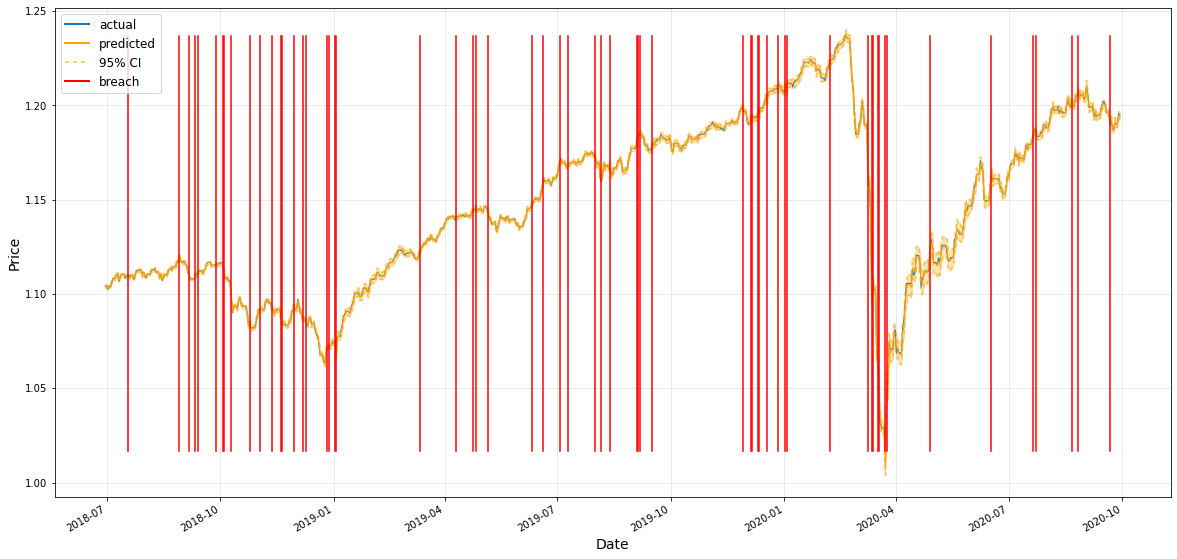

In [15]:
model_fund.plot()

#### Plot benchmark weights over time

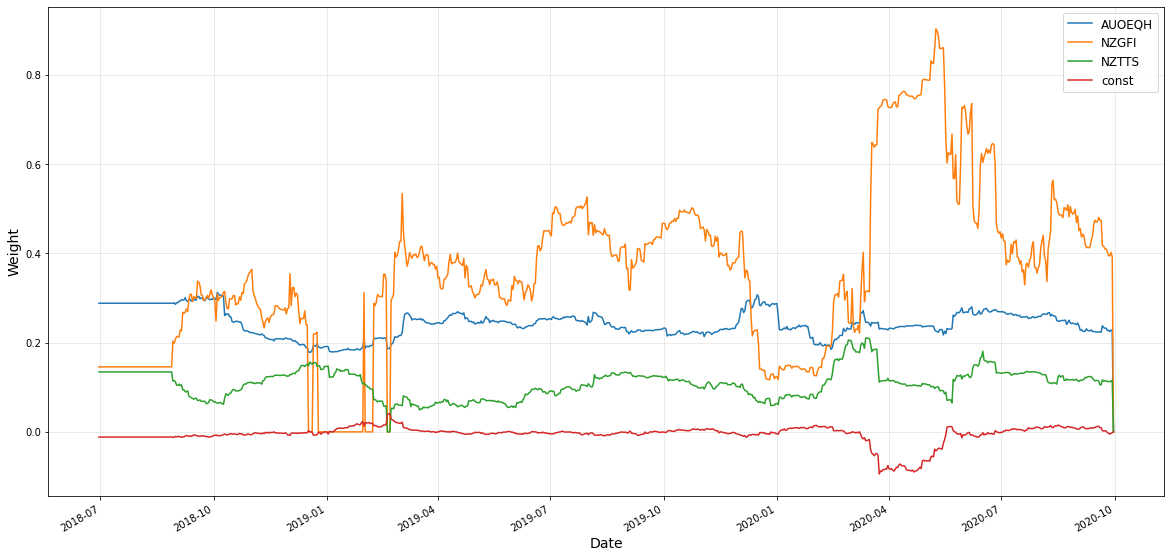

In [16]:
model_fund.plot_coeffs()